<a href="https://colab.research.google.com/github/FarahGamal/BigMart-Data-Analysis-and-Prediction/blob/main/mini_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement
The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim of this data science project is to build a predictive model and find out the sales of each product at a particular store.
Using this model, BigMart will try to understand the properties of products and stores which play a key role in increasing sales.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Hypothesis Generation

1- Establishment year affect the sales as it is more popular and known to the custmers.

2- Outlet location affect sales as different locations differ in customer number.

3- Product price affect badly on sales if it's high.

4- Outlet size affect variety of the product which affect the sales.

5- Product type: affect sales as the customer may be drawn into certain product types.

# Loading Packages and Data


## Imports

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import sklearn.metrics as sm
from google.colab import files
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from prettytable import PrettyTable
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

## Description of dataset

**Item_Identifier**: A code to identify each product.

**Item_Weight**: The product weight.

**Item_Fat_Content**: Indicates the fat content of the product.

**Item_Visibility**: The percentage of total display area in the store allocated to the particular product.

**Item_Type**: The category that the product belongs.

**Item_MRP**: The maximum retail price of the product.

**Outlet_Identifier**: A code identify each store.

**Outlet_Establishment_Year**: The establish year of the store.

**Outlet_Size**: The size of the store.

**Outlet_Location_Type**: The type of city where the store in.

**Outlet_Type**: The type of outlet.

**Item_Outlet_Sales**: The sales of the product in the store **Target**.

**Categorical Features:**

Item_Identifier

Item_Fat_Content

Item_Type

Outlet_Identifier

Outlet_Size

Outlet_Location_Type

Outlet_Type

**Continuous Features:**

Item_Weight

Item_Visibility

Item_MRP

Outlet_Establishment_Year

**Target:**

Item_Outlet_Sales

## Load Dataset and view it

In [ ]:
train= pd.read_csv("/content/drive/MyDrive/technocolabs/Train.csv")
test= pd.read_csv("/content/drive/MyDrive/technocolabs/Test.csv")

# Data Structure and Content

In [ ]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [ ]:
test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


# Univariate Analysis

## Continuous Features

**Histogram**


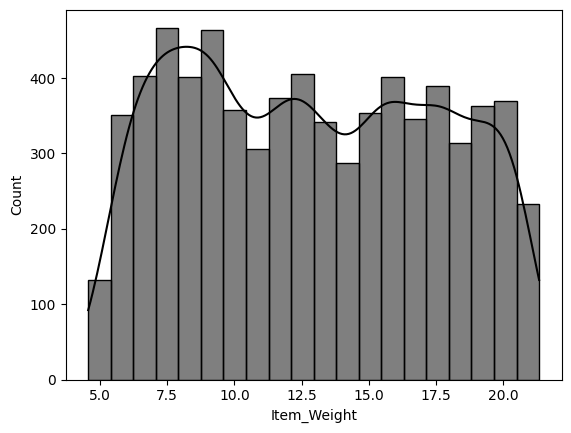

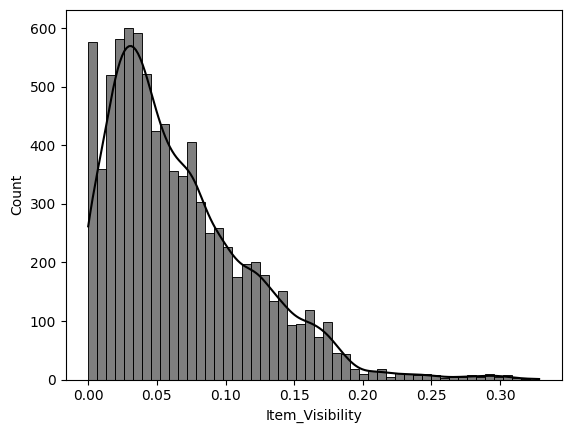

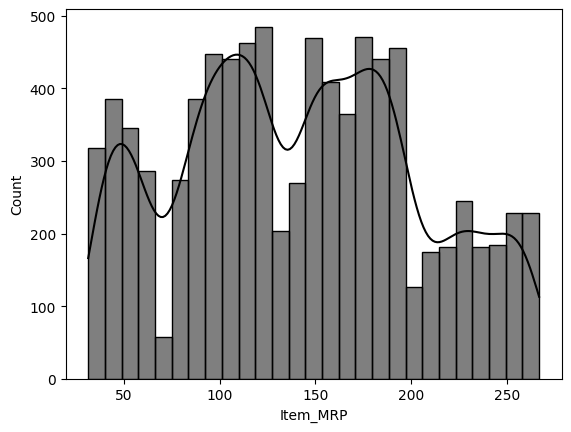

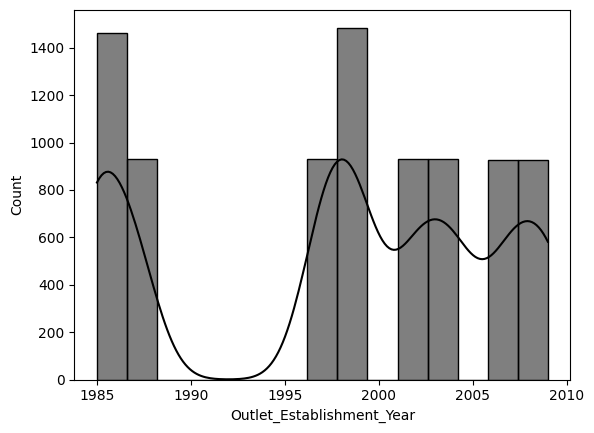

In [ ]:
continuous_features_list = ['Item_Weight','Item_Visibility','Item_MRP', 'Outlet_Establishment_Year']
for i in continuous_features_list:
  sns.histplot(train[i], kde=True, color='black')
  plt.show()

**Scatter plot**

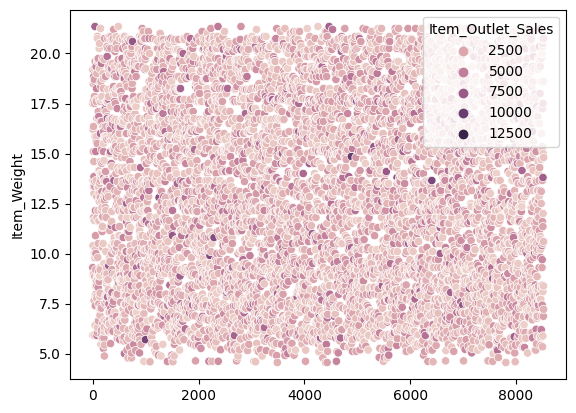

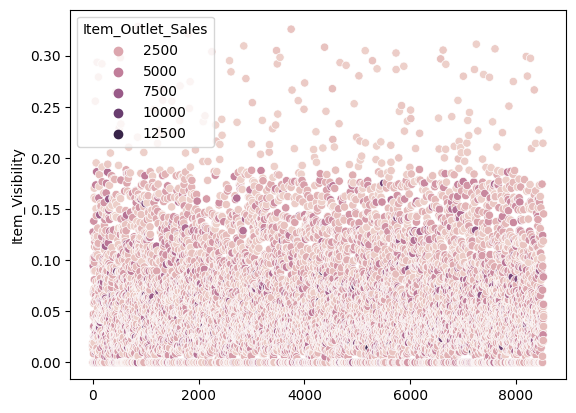

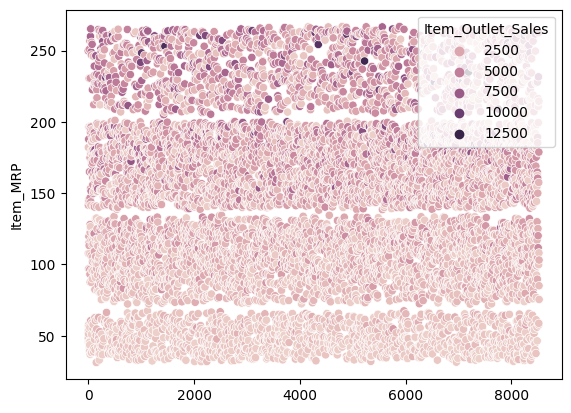

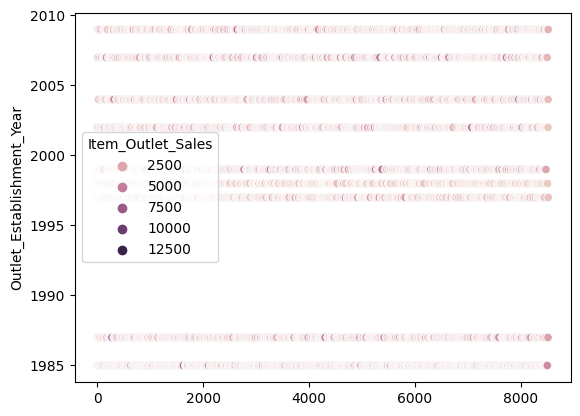

In [ ]:
for i in continuous_features_list:
  sns.scatterplot(x=train.index,y=train[i], hue=train['Item_Outlet_Sales'] )
  plt.show()

## Categorical Features

**Bar chart**

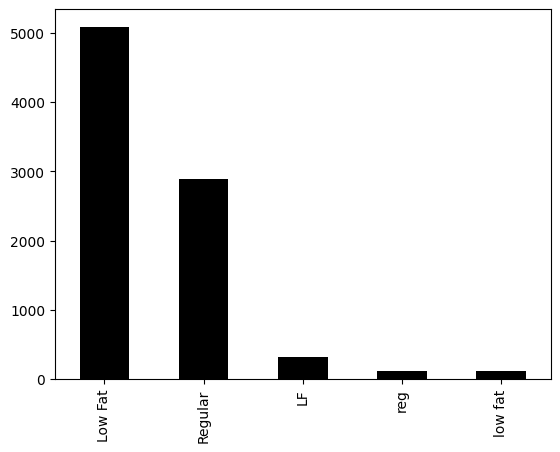

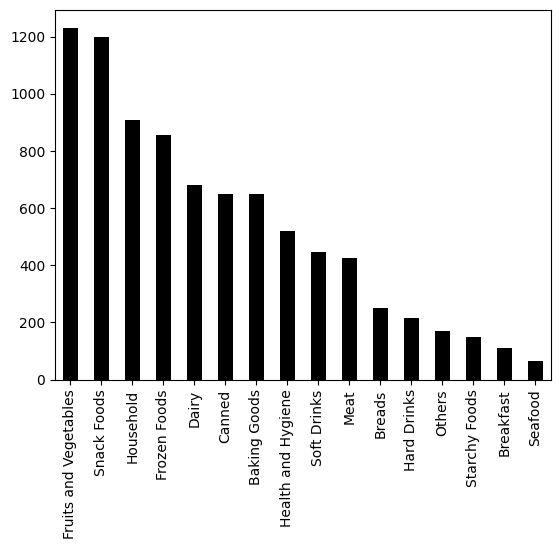

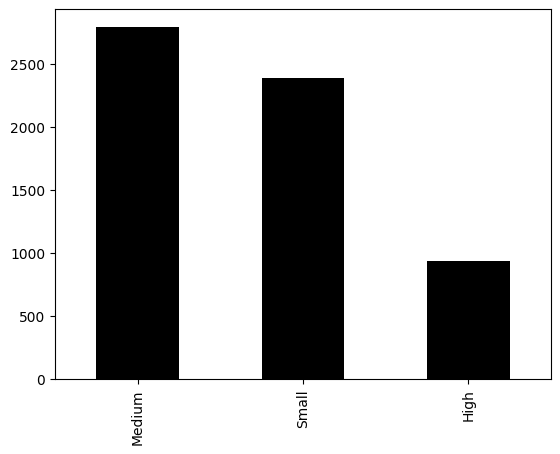

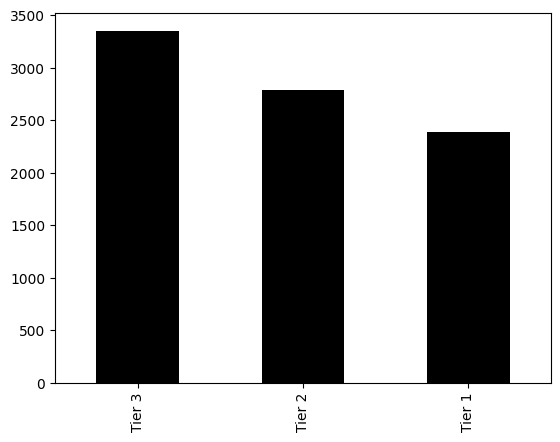

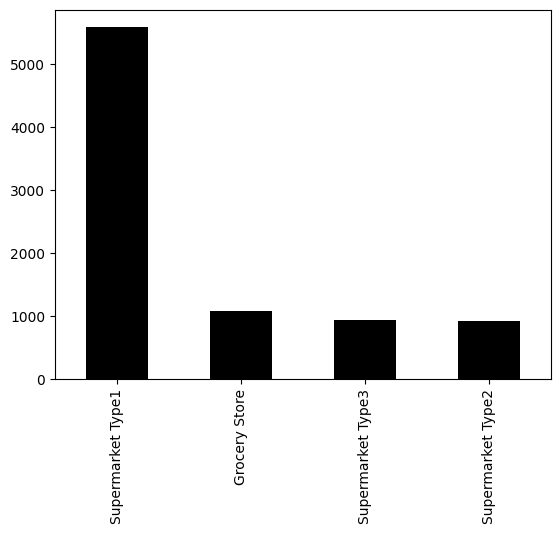

In [ ]:
categorical_features_list = ['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']
for i in categorical_features_list:
    train[i].value_counts().plot(kind='bar',color = 'black')
    plt.show()
# for i in range(len(categorical_features_list)):
#   plotBar_sex = train[categorical_features_list[i]].value_counts(sort= False)
#   px.bar(plotBar_sex, x = categorical_features_list[i], title = categorical_features_list[i]+str(' Bar Graph')).show()

# Bivariate Analysis

In [ ]:
train.corr()

<ipython-input-9-0bc27f030cd9>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.corr()


,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Weight,1.000000,-0.014048,0.027141,-0.011588,0.014123
Item_Visibility,-0.014048,1.000000,-0.001315,-0.074834,-0.128625
Item_MRP,0.027141,-0.001315,1.000000,0.005020,0.567574
Outlet_Establishment_Year,-0.011588,-0.074834,0.005020,1.000000,-0.049135
Item_Outlet_Sales,0.014123,-0.128625,0.567574,-0.049135,1.000000


<ipython-input-10-1af710c6362e>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(),annot=True,cmap="crest")


<Axes: >

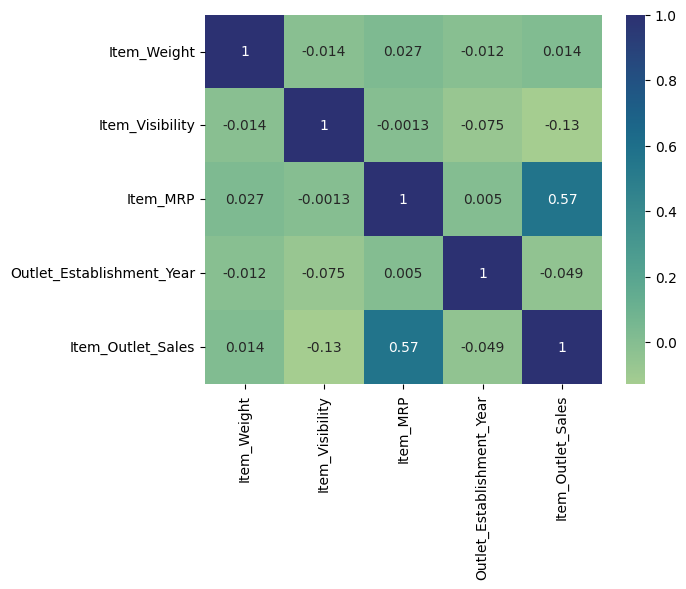

In [ ]:
sns.heatmap(train.corr(),annot=True,cmap="crest")

# Exploratory Data Analysis

In [ ]:
train.shape

(8523, 12)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [ ]:
train.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


# Missing Value Treatment

we check here for missing values.

we can fill item_weight using mean and outlet_size using mode.


In [ ]:
train.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [ ]:
train['Item_Weight'].fillna(train['Item_Weight'].mean(),inplace= True)

In [ ]:
train['Outlet_Size']

0       Medium
1       Medium
2       Medium
3          NaN
4         High
         ...  
8518      High
8519       NaN
8520     Small
8521    Medium
8522     Small
Name: Outlet_Size, Length: 8523, dtype: object

In [ ]:
train['Outlet_Size'].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [ ]:
train['Item_Weight'].value_counts()

12.857645    1463
12.150000      86
17.600000      82
13.650000      77
11.800000      76
             ... 
7.275000        2
7.685000        1
9.420000        1
6.520000        1
5.400000        1
Name: Item_Weight, Length: 416, dtype: int64

In [ ]:
train['Outlet_Size'].fillna(train['Outlet_Size'].mode()[0],inplace=True)

In [ ]:
train['Outlet_Size'].mode()

0    Medium
Name: Outlet_Size, dtype: object

In [ ]:
train.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [ ]:
test.isnull().sum()

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [ ]:
test['Item_Weight'].fillna(test['Item_Weight'].mean(),inplace= True)

In [ ]:
test['Outlet_Size'].fillna(test['Outlet_Size'].mode()[0],inplace=True)

## Duplicated Data

In [ ]:
# check for duplicate data
duplicate = train.duplicated()
print(duplicate.sum())
train[duplicate]

0


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales


In [ ]:
# check for duplicate data
duplicate = test.duplicated()
print(duplicate.sum())
test[duplicate]

0


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type


## Outliers

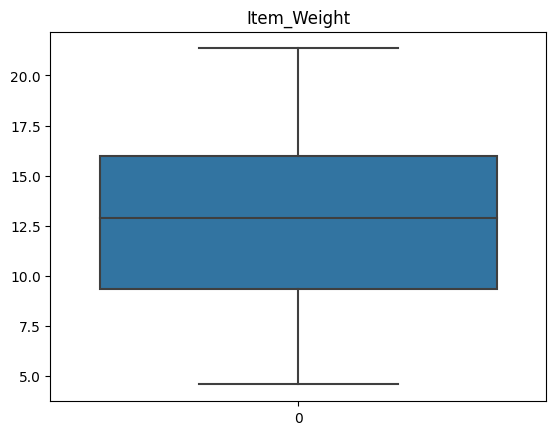

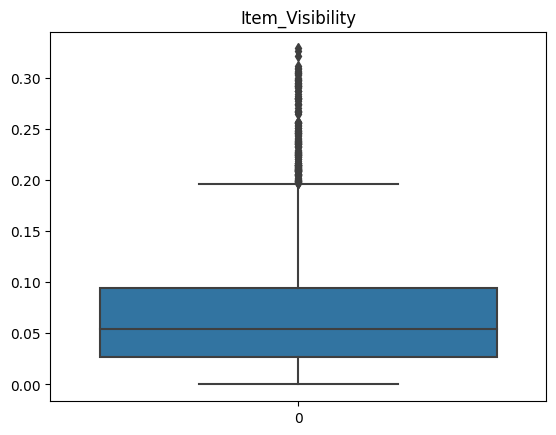

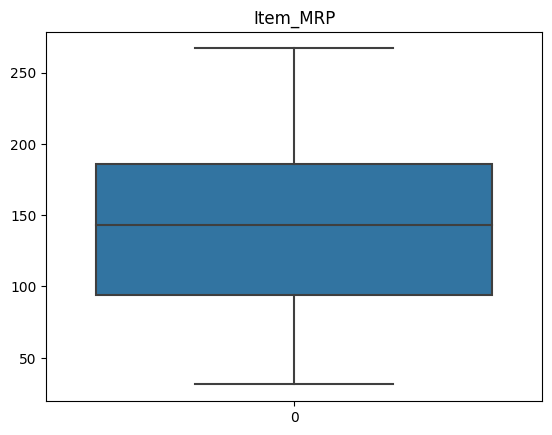

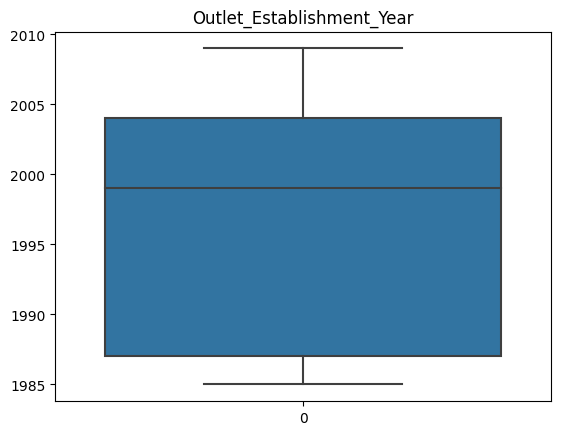

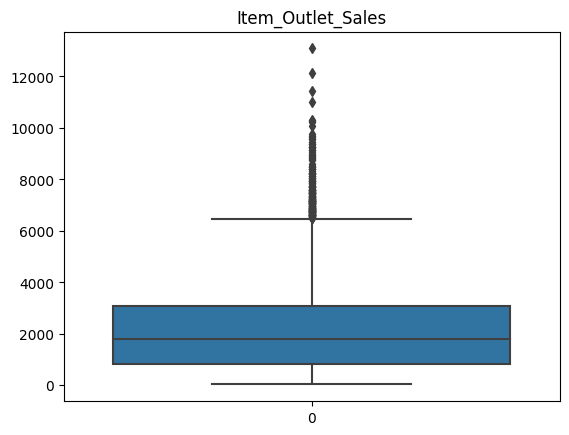

In [ ]:
# check for outliers using box plot
continuous_features = [feature for feature in train.columns if train[feature].dtype != 'object']
for feature in continuous_features:
    sns.boxplot(train[feature])
    plt.title(feature)
    plt.show()

In [ ]:
# handdel the outliers using IQR
def remove_outliers(column):
    sorted(column)
    q1, q3 = column.quantile([0.25, 0.75])
    IQR = q3 - q1
    lower_range = q1 - (1.5*IQR)
    upper_range = q3 + (1.5*IQR)
    return lower_range, upper_range

In [ ]:
lower_range, upper_range = remove_outliers(train['Item_Visibility'])
train['Item_Visibility'] = np.where(train['Item_Visibility'] > upper_range, upper_range, train['Item_Visibility'])
train['Item_Visibility'] = np.where(train['Item_Visibility'] < lower_range, lower_range, train['Item_Visibility'])

<Axes: >

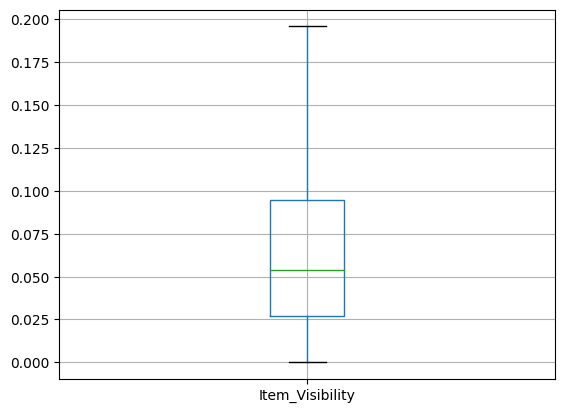

In [ ]:
train.boxplot(column=['Item_Visibility'])

## Bad Naming

In [ ]:
train['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [ ]:
test['Item_Fat_Content'].unique()

array(['Low Fat', 'reg', 'Regular', 'LF', 'low fat'], dtype=object)

In [ ]:
train['Item_Fat_Content'].replace('low fat','Low Fat',inplace=True)
train['Item_Fat_Content'].replace('LF','Low Fat',inplace=True)
train['Item_Fat_Content'].replace('reg','Regular',inplace=True)

test['Item_Fat_Content'].replace('low fat','Low Fat',inplace=True)
test['Item_Fat_Content'].replace('LF','Low Fat',inplace=True)
test['Item_Fat_Content'].replace('reg','Regular',inplace=True)

In [ ]:
train['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular'], dtype=object)

In [ ]:
test['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular'], dtype=object)

In [ ]:
standard_scaler = StandardScaler()

train['Item_Visibility'] = standard_scaler.fit_transform(train[['Item_Visibility']])
train['Item_Weight'] = standard_scaler.fit_transform(train[['Item_Weight']])
train['Item_MRP'] = standard_scaler.fit_transform(train[['Item_MRP']])

test['Item_Visibility'] = standard_scaler.fit_transform(test[['Item_Visibility']])
test['Item_Weight'] = standard_scaler.fit_transform(test[['Item_Weight']])
test['Item_MRP'] = standard_scaler.fit_transform(test[['Item_MRP']])

In [ ]:
train.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8.523000e+03,8.523000e+03,8.523000e+03,8523.000000,8523.000000
mean,3.755714e-16,1.817415e-16,-1.579818e-16,1997.831867,2181.288914
std,1.000059e+00,1.000059e+00,1.000059e+00,8.371760,1706.499616
min,-1.964716e+00,-1.337208e+00,-1.761688e+00,1985.000000,33.290000
25%,-8.395053e-01,-7.845791e-01,-7.574307e-01,1987.000000,834.247400
50%,0.000000e+00,-2.329331e-01,3.243893e-02,1999.000000,1794.331000
75%,7.435985e-01,5.994945e-01,7.170372e-01,2004.000000,3101.296400
max,2.009608e+00,2.675605e+00,2.021724e+00,2009.000000,13086.964800


In [ ]:
test.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
count,5.681000e+03,5.681000e+03,5.681000e+03,5681.000000
mean,4.027368e-16,-7.129191e-17,4.655862e-16,1997.828903
std,1.000088e+00,1.000088e+00,1.000088e+00,8.372256
min,-1.917783e+00,-1.281690e+00,-1.764188e+00,1985.000000
25%,-8.246845e-01,-7.539239e-01,-7.541832e-01,1987.000000
50%,4.184768e-16,-2.249774e-01,6.344716e-03,1999.000000
75%,7.431104e-01,5.420473e-01,7.281662e-01,2004.000000
max,2.038809e+00,5.033447e+00,2.031678e+00,2009.000000


## Label Encoding

In [ ]:
categorical_cols = ['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Outlet_Establishment_Year']
for col in categorical_cols:
    print(col, "number of unique values is", train[col].nunique())

Item_Fat_Content number of unique values is 2
Item_Type number of unique values is 16
Outlet_Size number of unique values is 3
Outlet_Location_Type number of unique values is 3
Outlet_Type number of unique values is 4
Outlet_Establishment_Year number of unique values is 9


In [ ]:
low_cardinality_cols = [col for col in categorical_cols if train[col].nunique() <= 10]
high_cardinality_cols = [col for col in categorical_cols if train[col].nunique() > 10]

print('Low Cardinality Columns:', low_cardinality_cols)
print('High Cardinality Columns:', high_cardinality_cols)

Low Cardinality Columns: ['Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Outlet_Establishment_Year']
High Cardinality Columns: ['Item_Type']


In [ ]:
# only for category data
for i in high_cardinality_cols:
    train[i]= LabelEncoder().fit_transform(train[i])
    test[i]= LabelEncoder().fit_transform(test[i])

In [ ]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,-0.841872,Low Fat,-1.008628,4,1.747454,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,-1.641706,Regular,-0.942473,14,-1.489023,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,1.098554,Low Fat,-0.994034,10,0.010040,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,1.500838,Regular,-1.337208,6,0.660050,OUT010,1998,Medium,Tier 3,Grocery Store,732.3800
4,NCD19,-0.929428,Low Fat,-1.337208,9,-1.399220,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## One Hot Encoding

In [ ]:
train = pd.get_dummies(train, columns = low_cardinality_cols)
test = pd.get_dummies(test, columns = low_cardinality_cols)

In [ ]:
train

,Item_Identifier,Item_Weight,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Item_Outlet_Sales,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Outlet_Size_High,...,Outlet_Type_Supermarket Type3,Outlet_Establishment_Year_1985,Outlet_Establishment_Year_1987,Outlet_Establishment_Year_1997,Outlet_Establishment_Year_1998,Outlet_Establishment_Year_1999,Outlet_Establishment_Year_2002,Outlet_Establishment_Year_2004,Outlet_Establishment_Year_2007,Outlet_Establishment_Year_2009
0,FDA15,-0.841872,-1.008628,4,1.747454,OUT049,3735.1380,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,DRC01,-1.641706,-0.942473,14,-1.489023,OUT018,443.4228,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,FDN15,1.098554,-0.994034,10,0.010040,OUT049,2097.2700,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,FDX07,1.500838,-1.337208,6,0.660050,OUT010,732.3800,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4,NCD19,-0.929428,-1.337208,9,-1.399220,OUT013,994.7052,1,0,1,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,-1.418084,-0.174527,13,1.180783,OUT013,2778.3834,1,0,1,...,0,0,1,0,0,0,0,0,0,0
8519,FDS36,-1.059578,-0.375209,0,-0.527301,OUT045,549.2850,0,1,0,...,0,0,0,0,0,0,1,0,0,0
8520,NCJ29,-0.534243,-0.616744,8,-0.897208,OUT035,1193.1136,1,0,0,...,0,0,0,0,0,0,0,1,0,0
8521,FDN46,-1.336444,1.636290,13,-0.607977,OUT018,1845.5976,0,1,0,...,0,0,0,0,0,0,0,0,0,1


# Seperating Training And Test Data

In [ ]:
y = train['Item_Outlet_Sales']
X = train.drop('Item_Outlet_Sales',axis=1)
X = X.drop('Item_Identifier',axis=1)
X = X.drop('Outlet_Identifier',axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=1)

print('X_train size:', X_train.shape)
print('y_train size:', y_train.shape)
print('X_valid size:', X_valid.shape)
print('y_valid size:', y_valid.shape)

X_train size: (6818, 25)
y_train size: (6818,)
X_valid size: (1705, 25)
y_valid size: (1705,)


# Running The Models

In [ ]:
X_train

,Item_Weight,Item_Visibility,Item_Type,Item_MRP,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,...,Outlet_Type_Supermarket Type3,Outlet_Establishment_Year_1985,Outlet_Establishment_Year_1987,Outlet_Establishment_Year_1997,Outlet_Establishment_Year_1998,Outlet_Establishment_Year_1999,Outlet_Establishment_Year_2002,Outlet_Establishment_Year_2004,Outlet_Establishment_Year_2007,Outlet_Establishment_Year_2009
1945,1.299696,0.492197,9,0.818315,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1720,1.063059,2.104043,9,0.566527,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1954,-0.652562,-0.233827,6,1.358826,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1919,-0.475084,1.998360,13,-0.578605,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2461,-1.345909,-0.114465,6,-0.160523,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,0.000000,2.675605,10,0.247334,0,1,0,0,1,1,...,0,1,0,0,0,0,0,0,0,0
7813,0.000000,2.311421,4,-1.381006,1,0,0,0,1,1,...,0,1,0,0,0,0,0,0,0,0
905,1.181378,0.010300,5,0.130272,1,0,0,0,1,1,...,0,0,0,1,0,0,0,0,0,0
5192,-0.770880,-0.321248,9,-1.554231,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


## Linear Regression

In [ ]:
from sklearn.metrics import accuracy_score

linear_regression = LinearRegression()
linear_regression.fit(X_train,y_train)
linear_regression_predictions = linear_regression.predict(X_valid)

print("R2 score =", round(sm.r2_score(y_valid, linear_regression_predictions), 2))
print("Mean absolute error =", round(sm.mean_absolute_error(y_valid, linear_regression_predictions), 2))
print("Accuracy = ",round((1 - (sm.mean_absolute_error(y_valid, linear_regression_predictions) / y_valid.mean()))*100,2),"%")

R2 score = 0.56
Mean absolute error = 851.29
Accuracy =  60.22 %


In [ ]:
linear_result = pd.DataFrame({'Actual' : y_valid, 'Predicted' : linear_regression_predictions})

In [ ]:
linear_result

,Actual,Predicted
1070,952.7598,552.275826
6305,1133.8574,1193.193864
8504,4138.6128,3242.623721
5562,1657.1762,1450.356544
1410,679.1160,782.504748
...,...,...
376,5715.2272,3085.624981
7708,4832.3764,3815.906862
3812,2972.1312,2657.052379
3928,2492.7552,2329.631376


## Regularized Linear Regression

In [ ]:
regularized_linear_regression = Ridge(alpha=0,random_state=1)
regularized_linear_regression.fit(X_train, y_train)
regularized_linear_regression_predictions = regularized_linear_regression.predict(X_valid)

ridge_result = pd.DataFrame({'Actual' : y_valid, 'Predicted' : regularized_linear_regression_predictions})

print("R2 score =", round(sm.r2_score(y_valid, regularized_linear_regression_predictions), 2))
print("Mean absolute error =", round(sm.mean_absolute_error(y_valid, regularized_linear_regression_predictions), 2))
print("Accuracy = ",round((1 - (sm.mean_absolute_error(y_valid, regularized_linear_regression_predictions) / y_valid.mean()))*100,2),"%")

R2 score = 0.56
Mean absolute error = 858.81
Accuracy =  59.87 %


In [ ]:
ridge_result

,Actual,Predicted
1070,952.7598,544.0
6305,1133.8574,1200.0
8504,4138.6128,3264.0
5562,1657.1762,1488.0
1410,679.1160,688.0
...,...,...
376,5715.2272,3248.0
7708,4832.3764,3888.0
3812,2972.1312,2672.0
3928,2492.7552,2368.0


## RandomForest

In [ ]:
random_forest = RandomForestRegressor()
random_forest.fit(X_train,y_train)
random_forest_predictions = random_forest.predict(X_valid)

random_forest_result = pd.DataFrame({'Actual' : y_valid, 'Predicted' : random_forest_predictions})

print("R2 score =", round(sm.r2_score(y_valid, random_forest_predictions), 2))
print("Mean absolute error =", round(sm.mean_absolute_error(y_valid, random_forest_predictions), 2))
print("Accuracy = ",round((1 - (sm.mean_absolute_error(y_valid, random_forest_predictions) / y_valid.mean()))*100,2),"%")

R2 score = 0.55
Mean absolute error = 797.92
Accuracy =  62.71 %


In [ ]:
random_forest_result

,Actual,Predicted
1070,952.7598,543.951942
6305,1133.8574,1320.900594
8504,4138.6128,3402.344528
5562,1657.1762,1299.035722
1410,679.1160,619.786562
...,...,...
376,5715.2272,3321.636252
7708,4832.3764,3887.659464
3812,2972.1312,2793.144186
3928,2492.7552,1730.640572


## XGBoost

In [ ]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_valid)
xgb_mean_square_error = round(sm.mean_absolute_error(y_valid, xgb_pred), 2)
xgb_r2_score = r2_score(y_valid, xgb_pred)

xgb_result = pd.DataFrame({'Actual' : y_valid, 'Predicted' : xgb_pred})

print("XGBoost MAE:", xgb_mean_square_error)
print("XGBoost R2 score:", xgb_r2_score)
print("Accuracy = ",round((1 - (xgb_mean_square_error/ y_valid.mean()))*100,2),"%")

XGBoost MAE: 834.33
XGBoost R2 score: 0.5147108254221052
Accuracy =  61.01 %


In [ ]:
xgb_result

,Actual,Predicted
1070,952.7598,421.448334
6305,1133.8574,1472.116821
8504,4138.6128,3361.181152
5562,1657.1762,1570.518799
1410,679.1160,740.736694
...,...,...
376,5715.2272,2960.150635
7708,4832.3764,3246.593994
3812,2972.1312,2647.381836
3928,2492.7552,1852.267456


## Testing the model

In [ ]:
copy_test = test.copy(deep = True)
test = test.drop('Outlet_Identifier',axis=1)
test = test.drop('Item_Identifier',axis=1)

In [ ]:
prediction = random_forest.predict(test)
print(prediction)

[1756.320478 1550.894546  690.381336 ... 1524.275862 4484.815484
 1336.134098]


In [ ]:
result = pd.DataFrame({'Item_Identifier' : copy_test['Outlet_Identifier'], 'Outlet_Identifier': copy_test['Outlet_Identifier'], 'Predicted' : prediction})
result

,Item_Identifier,Outlet_Identifier,Predicted
0,OUT049,OUT049,1756.320478
1,OUT017,OUT017,1550.894546
2,OUT010,OUT010,690.381336
3,OUT017,OUT017,2106.984022
4,OUT027,OUT027,6064.738910
...,...,...,...
5676,OUT046,OUT046,2228.985214
5677,OUT018,OUT018,2943.601670
5678,OUT045,OUT045,1524.275862
5679,OUT017,OUT017,4484.815484


# Saving the result

In [ ]:
result.to_csv('/content/drive/MyDrive/technocolabs/result.csv', index=False)
# files.download('/content/sample_data/my_file.csv')